In [27]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [28]:
# Setting path to input files
file = "Super_Sales.csv"

In [29]:
# Creating dataframes
data = pd.read_csv(file)
df = pd.DataFrame(data)

In [30]:
#Pre processing for XGB Model

# Select relevant features and convert 'Order Date' to datetime
sales_df = df[['Order Date', 'Sales']]
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])

# Set 'Order Date' as index
sales_df.set_index('Order Date', inplace=True)

# Resample the data on a monthly basis and aggregate the sales
monthly_sales = sales_df.resample('M').sum()

# Hyperparameter tuning
# Defining parameter grid for GridSearchCV

param_grid = {
    'n_estimators' :[100, 200, 300], # Number of trees in this forest
    'max_depth' : [3, 5, 7], # Maximum depth of the tree
    'learning_rate' : [0.05, 0.1, 0.2], # Learning rate
    'subsample' : [0.7, 0.8, 0.9], # Subsample ratio of training instance
    'colsample_bytree' : [0.7, 0.8, 0.9] # Subsample ratio of columns when constructing each tree
}

# Splitting data into training and testing sets
train = monthly_sales[:-15]  # Training data (all except last 16 months)
test = monthly_sales[-15:]   # Testing data (last 16 months)

# Initialize XGBoost model
xgb = XGBRegressor()

# Initialize GridSearchCV with the XGBoost model and parameter grid
grid_search = GridSearchCV(estimator = xgb, param_grid=param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

# Fit the GridSearchCV to the training data
grid_search.fit(train.index.month.values.reshape(-1, 1), train.values)

# Get the best hyperparameters
gs_params = grid_search.best_params_
print("Best hyperparameters", gs_params)

# Use the best hyperparameters to train the final model
gs_model = XGBRegressor(**gs_params)
gs_model.fit(train.index.month.values.reshape(-1,1), train.values)

/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/3670738429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'])


Best hyperparameters {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# XGB Model without hyperparameters

# Initialize XGBoost model
model = XGBRegressor()

# Fit the model to the training data
model.fit(train.index.month.values.reshape(-1, 1), train.values)

# Predict on the test set
basic_predictions = model.predict(test.index.month.values.reshape(-1, 1))

# Evaluate rmse
basic_rmse = mean_squared_error(test.values, basic_predictions, squared=False)

In [32]:
# Predict on the test set
gs_predictions = gs_model.predict(test.index.month.values.reshape(-1, 1))

# Evaluate the model
gs_rmse = mean_squared_error(test.values, gs_predictions, squared=False)

In [33]:
# Finding rmse
print("GridSearch hyperparameter RMSE:", gs_rmse)
print("Basic TSF RMSE:", basic_rmse)

GridSearch hyperparameter RMSE: 21019.816184142266
Basic TSF RMSE: 20901.448136378054


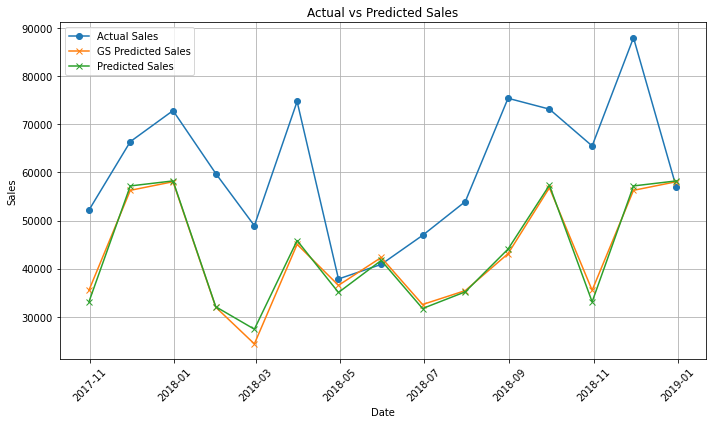

In [34]:
# Plotting results and comparing

plt.figure(figsize = (10,6))

# Plotting actual values
plt.plot(test.index, test.values, label = 'Actual Sales', marker = 'o')

# Plotting (hyperparameter) predicted values
plt.plot(test.index, gs_predictions, label = 'GS Predicted Sales', marker = 'x')

# Plotting basic predicted values
plt.plot(test.index, basic_predictions, label = 'Predicted Sales', marker = 'x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()

# Display plot
plt.grid(True)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Epoch [10/100], Loss: 372129.7500
Epoch [20/100], Loss: 371995.5000
Epoch [30/100], Loss: 371816.0312
Epoch [40/100], Loss: 371567.8125
Epoch [50/100], Loss: 371225.9062
Epoch [60/100], Loss: 370757.6562
Epoch [70/100], Loss: 370131.2500
Epoch [80/100], Loss: 369314.3125
Epoch [90/100], Loss: 368275.1250
Epoch [100/100], Loss: 366984.3125
Root Mean Squared Error on Test Data: 856.9223


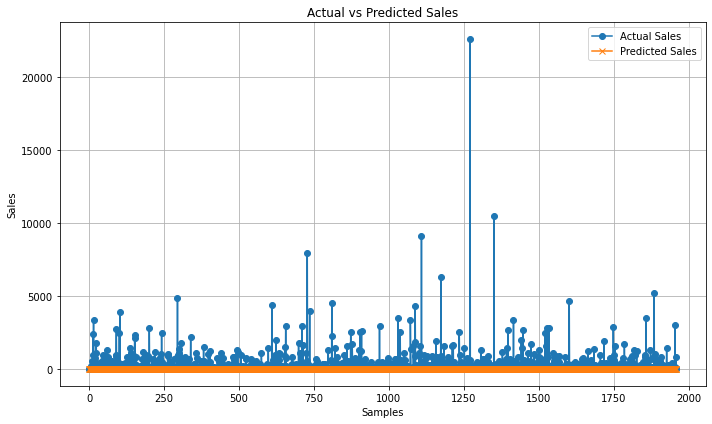

In [35]:
#Pytorch Model 1
# Neural Network Model using Pytorch

# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = ['Order Year', 'Order Month', 'Order Day', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
X = df[features]
y = df['Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    rmse = torch.sqrt(mse)
    pytorch_rmse_1 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {rmse.item():.4f}')

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.numpy(), label='Actual Sales', marker='o')
plt.plot(predictions.numpy(), label='Predicted Sales', marker='x')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch [10/100], Loss: 371953.7812


/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/4151022498.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Date'] = df['Order Date']


Epoch [20/100], Loss: 371779.9062
Epoch [30/100], Loss: 371535.6875
Epoch [40/100], Loss: 371196.4375
Epoch [50/100], Loss: 370732.4688
Epoch [60/100], Loss: 370110.6562
Epoch [70/100], Loss: 369296.0312
Epoch [80/100], Loss: 368253.1562
Epoch [90/100], Loss: 366948.8438
Epoch [100/100], Loss: 365353.6562
Root Mean Squared Error on Test Data: 855.6850


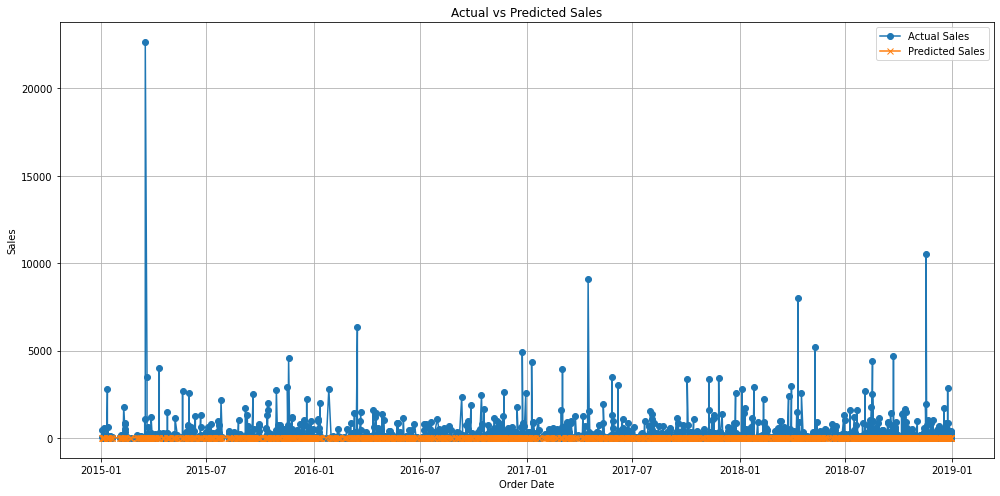

In [36]:
#Pytorch Model 2
# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = ['Order Year', 'Order Month', 'Order Day', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
X = df[features]
y = df['Sales']

# Include 'Order Date' in the test set
X['Order Date'] = df['Order Date']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Order Date' for plotting
X_test_dates = X_test['Order Date']
X_train = X_train.drop(columns='Order Date')
X_test = X_test.drop(columns='Order Date')

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    rmse = torch.sqrt(mse)
    pytorch_rmse_2 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {rmse.item():.4f}')

# Prepare data for plotting
predictions = predictions.numpy().flatten()
y_test = y_test.numpy().flatten()
results_df = pd.DataFrame({'Order Date': X_test_dates, 'Actual Sales': y_test, 'Predicted Sales': predictions})
results_df = results_df.sort_values('Order Date')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results_df['Order Date'], results_df['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(results_df['Order Date'], results_df['Predicted Sales'], label='Predicted Sales', marker='x')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/1749680108.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Date'] = df['Order Date']


Epoch [10/100], Loss: 372062.8438
Epoch [20/100], Loss: 371934.3438
Epoch [30/100], Loss: 371767.4062
Epoch [40/100], Loss: 371538.3750
Epoch [50/100], Loss: 371220.5938
Epoch [60/100], Loss: 370783.3438
Epoch [70/100], Loss: 370194.5938
Epoch [80/100], Loss: 369422.1562
Epoch [90/100], Loss: 368433.7188
Epoch [100/100], Loss: 367199.0000
Root Mean Squared Error on Test Data: 857.0657


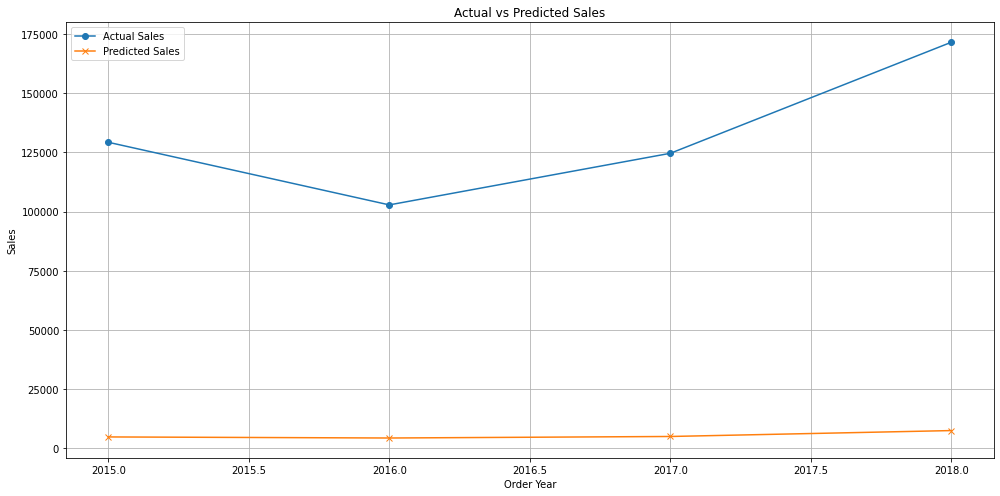

In [37]:
#Pytorch Model 3
# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = ['Order Year', 'Order Month', 'Order Day', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
X = df[features]
y = df['Sales']

# Include 'Order Date' in the test set
X['Order Date'] = df['Order Date']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Order Date' for plotting
X_test_dates = X_test['Order Date']
X_train = X_train.drop(columns='Order Date')
X_test = X_test.drop(columns='Order Date')

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)    
    rmse = torch.sqrt(mse)
    pytorch_rmse_3 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {rmse.item():.4f}')

# Prepare data for plotting
predictions = predictions.numpy().flatten()
y_test = y_test.numpy().flatten()
results_df = pd.DataFrame({'Order Date': X_test_dates, 'Actual Sales': y_test, 'Predicted Sales': predictions})
results_df['Order Year'] = results_df['Order Date'].dt.year

# Group by year and sum sales
grouped_results = results_df.groupby('Order Year').sum().reset_index()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(grouped_results['Order Year'], grouped_results['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(grouped_results['Order Year'], grouped_results['Predicted Sales'], label='Predicted Sales', marker='x')
plt.xlabel('Order Year')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/738516212.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Date'] = df['Order Date']


Epoch [10/300], Train Loss: 371932.5625, Validation Loss: 740726.6250
Epoch [20/300], Train Loss: 371318.5625, Validation Loss: 739918.3125
Epoch [30/300], Train Loss: 369944.0938, Validation Loss: 738094.8750
Epoch [40/300], Train Loss: 367208.9062, Validation Loss: 734507.2500
Epoch [50/300], Train Loss: 362139.9688, Validation Loss: 728152.9375
Epoch [60/300], Train Loss: 354399.7500, Validation Loss: 718058.6875
Epoch [70/300], Train Loss: 343841.0000, Validation Loss: 703854.2500
Epoch [80/300], Train Loss: 331621.6562, Validation Loss: 687080.1250
Epoch [90/300], Train Loss: 322784.8750, Validation Loss: 672559.5625
Epoch [100/300], Train Loss: 319553.5625, Validation Loss: 665376.5000
Epoch [110/300], Train Loss: 319659.1562, Validation Loss: 663573.5625
Epoch [120/300], Train Loss: 318319.5625, Validation Loss: 663567.6875
Epoch [130/300], Train Loss: 317848.9062, Validation Loss: 663492.3125
Epoch [140/300], Train Loss: 316639.0625, Validation Loss: 662473.1250
Epoch [150/300]

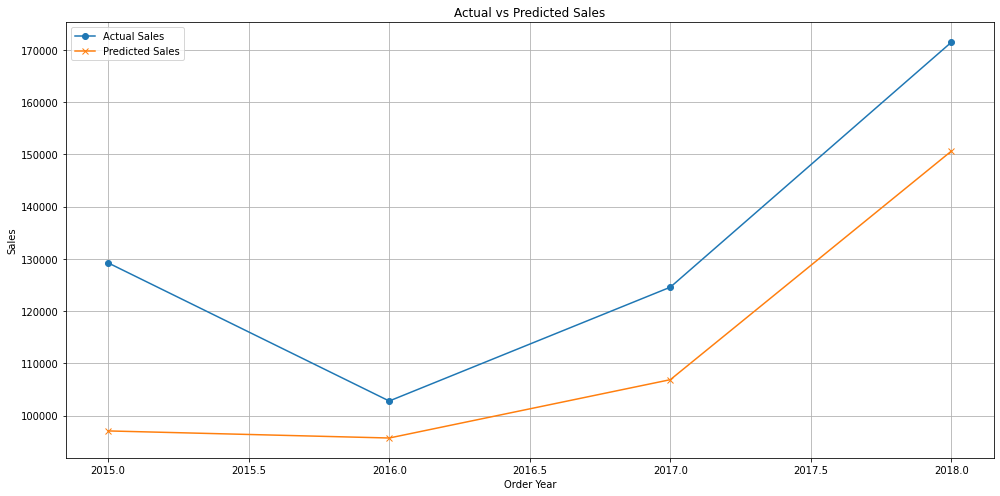

In [39]:
#Pytorch Model 4
# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day

# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = ['Order Year', 'Order Month', 'Order Day', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
X = df[features]
y = df['Sales']

# Include 'Order Date' in the test set
X['Order Date'] = df['Order Date']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Order Date' for plotting
X_test_dates = X_test['Order Date']
X_train = X_train.drop(columns='Order Date')
X_test = X_test.drop(columns='Order Date')

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network with dropout for regularization
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
epochs = 300
patience = 20
best_loss = float('inf')
counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model = model.state_dict()
    else:
        counter += 1
        
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Load the best model
model.load_state_dict(best_model)

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    rmse = torch.sqrt(mse)
    pytorch_rmse_4 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {pytorch_rmse_4:.4f}')



# Prepare data for plotting
predictions = predictions.numpy().flatten()
y_test = y_test.numpy().flatten()
results_df = pd.DataFrame({'Order Date': X_test_dates, 'Actual Sales': y_test, 'Predicted Sales': predictions})
results_df['Order Year'] = results_df['Order Date'].dt.year

# Group by year and sum sales
grouped_results = results_df.groupby('Order Year').sum().reset_index()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(grouped_results['Order Year'], grouped_results['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(grouped_results['Order Year'], grouped_results['Predicted Sales'], label='Predicted Sales', marker='x')
plt.xlabel('Order Year')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/3739013135.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Date'] = df['Order Date']
/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/3739013135.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Quarter'] = df['Order Quarter']


Epoch [10/300], Train Loss: 372035.4062, Validation Loss: 740864.4375
Epoch [20/300], Train Loss: 371797.0938, Validation Loss: 740543.0625
Epoch [30/300], Train Loss: 371207.5000, Validation Loss: 739764.3750
Epoch [40/300], Train Loss: 369957.0000, Validation Loss: 738122.3125
Epoch [50/300], Train Loss: 367561.4062, Validation Loss: 734958.3750
Epoch [60/300], Train Loss: 363267.1562, Validation Loss: 729329.8750
Epoch [70/300], Train Loss: 356357.5312, Validation Loss: 720178.0000
Epoch [80/300], Train Loss: 346410.2812, Validation Loss: 706966.0625
Epoch [90/300], Train Loss: 334820.0312, Validation Loss: 690723.3750
Epoch [100/300], Train Loss: 325052.0312, Validation Loss: 675357.5000
Epoch [110/300], Train Loss: 320872.5312, Validation Loss: 666282.1875
Epoch [120/300], Train Loss: 320508.0938, Validation Loss: 663571.3125
Epoch [130/300], Train Loss: 319861.3125, Validation Loss: 663352.3125
Epoch [140/300], Train Loss: 318432.7812, Validation Loss: 663617.4375
Early stopping 

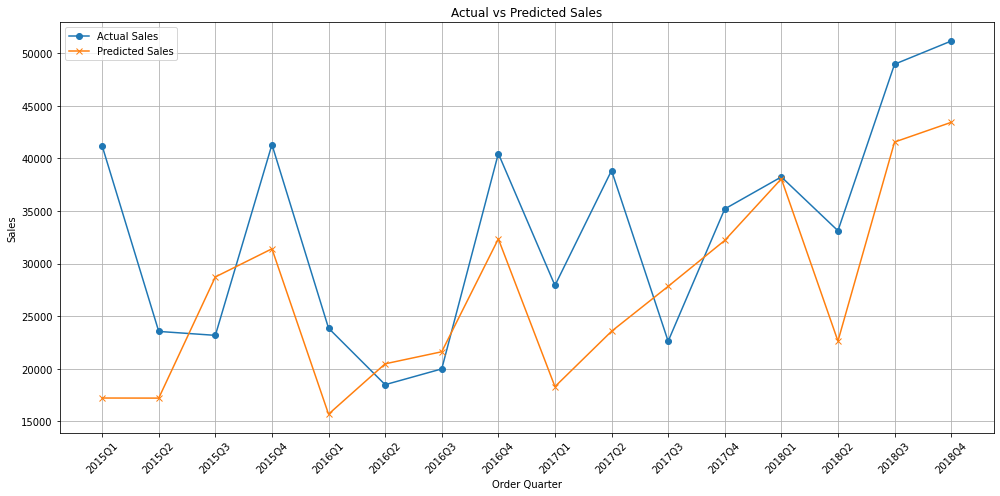

In [40]:
#Pytorch Model 5
# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Quarter'] = df['Order Date'].dt.to_period('Q')

# Add cyclical features
df['Month_Sin'] = np.sin(2 * np.pi * df['Order Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Order Month'] / 12)
df['Day_Sin'] = np.sin(2 * np.pi * df['Order Day'] / 31)
df['Day_Cos'] = np.cos(2 * np.pi * df['Order Day'] / 31)
df['Quarter_Sin'] = np.sin(2 * np.pi * df['Order Date'].dt.quarter / 4)
df['Quarter_Cos'] = np.cos(2 * np.pi * df['Order Date'].dt.quarter / 4)

# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = [
    'Order Year', 'Month_Sin', 'Month_Cos', 'Day_Sin', 'Day_Cos', 
    'Quarter_Sin', 'Quarter_Cos', 'Ship Mode', 'Segment', 'Country', 
    'City', 'State', 'Region', 'Category', 'Sub-Category'
]
X = df[features]
y = df['Sales']

# Include 'Order Date' and 'Order Quarter' in the test set
X['Order Date'] = df['Order Date']
X['Order Quarter'] = df['Order Quarter']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Order Date' and 'Order Quarter' for plotting
X_test_dates = X_test['Order Date']
X_test_quarters = X_test['Order Quarter']
X_train = X_train.drop(columns=['Order Date', 'Order Quarter'])
X_test = X_test.drop(columns=['Order Date', 'Order Quarter'])

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network with dropout for regularization
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
epochs = 300
patience = 20
best_loss = float('inf')
counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model = model.state_dict()
    else:
        counter += 1
        
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Load the best model
model.load_state_dict(best_model)

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    rmse = torch.sqrt(mse)
    pytorch_rmse_5 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {pytorch_rmse_5:.4f}')


# Prepare data for plotting
predictions = predictions.numpy().flatten()
y_test = y_test.numpy().flatten()
results_df = pd.DataFrame({'Order Date': X_test_dates, 'Order Quarter': X_test_quarters, 'Actual Sales': y_test, 'Predicted Sales': predictions})

# Group by quarter and sum sales
grouped_results = results_df.groupby('Order Quarter').sum().reset_index()

# Convert Period to string for plotting
grouped_results['Order Quarter'] = grouped_results['Order Quarter'].astype(str)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(grouped_results['Order Quarter'], grouped_results['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(grouped_results['Order Quarter'], grouped_results['Predicted Sales'], label='Predicted Sales', marker='x')
plt.xlabel('Order Quarter')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/3410375912.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Date'] = df['Order Date']
/var/folders/d4/7m9sw_1j7xs95mzgw84z3bp00000gn/T/ipykernel_21144/3410375912.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Order Quarter'] = df['Order Quarter']


Epoch [10/300], Train Loss: 371899.3750, Validation Loss: 740678.4375
Epoch [20/300], Train Loss: 371287.7500, Validation Loss: 739863.7500
Epoch [30/300], Train Loss: 369932.8125, Validation Loss: 738108.4375
Epoch [40/300], Train Loss: 367291.4375, Validation Loss: 734657.0625
Epoch [50/300], Train Loss: 362623.9375, Validation Loss: 728549.2500
Epoch [60/300], Train Loss: 355125.0000, Validation Loss: 718685.9375
Epoch [70/300], Train Loss: 344401.1250, Validation Loss: 704595.4375
Epoch [80/300], Train Loss: 332329.9688, Validation Loss: 687668.7500
Epoch [90/300], Train Loss: 323224.9688, Validation Loss: 672582.0000
Epoch [100/300], Train Loss: 319417.1250, Validation Loss: 664775.8125
Epoch [110/300], Train Loss: 320084.2188, Validation Loss: 662773.6250
Epoch [120/300], Train Loss: 318471.1250, Validation Loss: 662819.1250
Epoch [130/300], Train Loss: 317581.3750, Validation Loss: 662934.0625
Early stopping at epoch 134
Root Mean Squared Error on Test Data: 814.0556


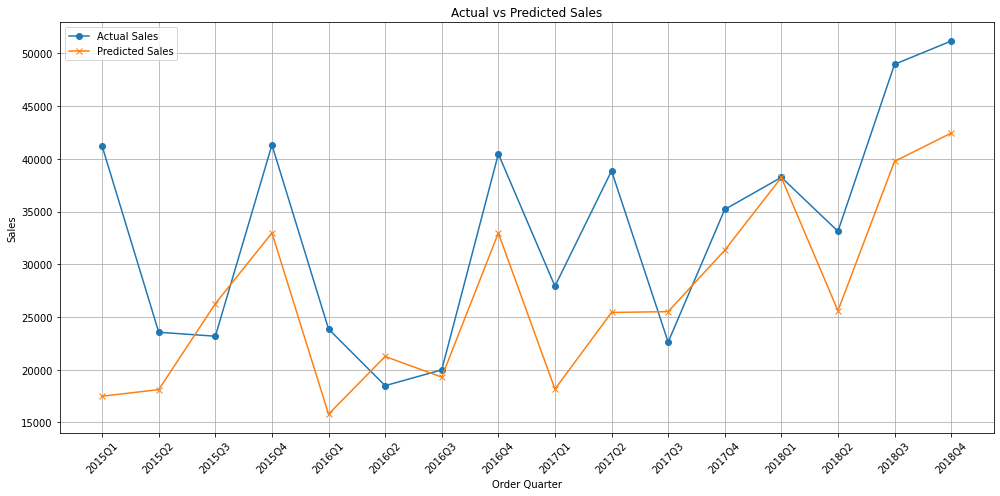

In [41]:
#Pytorch Model 6
# Load your DataFrame
df = pd.DataFrame(data)

# Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Order Quarter'] = df['Order Date'].dt.to_period('Q')

# Encode categorical features
label_encoders = {}
for column in ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define features and target
features = ['Order Year', 'Order Month', 'Order Day', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
X = df[features]
y = df['Sales']

# Include 'Order Date' in the test set
X['Order Date'] = df['Order Date']
X['Order Quarter'] = df['Order Quarter']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate 'Order Date' and 'Order Quarter' for plotting
X_test_dates = X_test['Order Date']
X_test_quarters = X_test['Order Quarter']
X_train = X_train.drop(columns=['Order Date', 'Order Quarter'])
X_test = X_test.drop(columns=['Order Date', 'Order Quarter'])

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network with dropout for regularization
class SalesPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SalesPredictor(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with early stopping
epochs = 300
patience = 20
best_loss = float('inf')
counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model = model.state_dict()
    else:
        counter += 1
        
    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Load the best model
model.load_state_dict(best_model)

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    rmse = torch.sqrt(mse)
    pytorch_rmse_6 = rmse.item()
    print(f'Root Mean Squared Error on Test Data: {pytorch_rmse_6:.4f}')


# Prepare data for plotting
predictions = predictions.numpy().flatten()
y_test = y_test.numpy().flatten()
results_df = pd.DataFrame({'Order Date': X_test_dates, 'Order Quarter': X_test_quarters, 'Actual Sales': y_test, 'Predicted Sales': predictions})

# Group by quarter and sum sales
grouped_results = results_df.groupby('Order Quarter').sum().reset_index()

# Convert Period to string for plotting
grouped_results['Order Quarter'] = grouped_results['Order Quarter'].astype(str)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(grouped_results['Order Quarter'], grouped_results['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(grouped_results['Order Quarter'], grouped_results['Predicted Sales'], label='Predicted Sales', marker='x')
plt.xlabel('Order Quarter')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


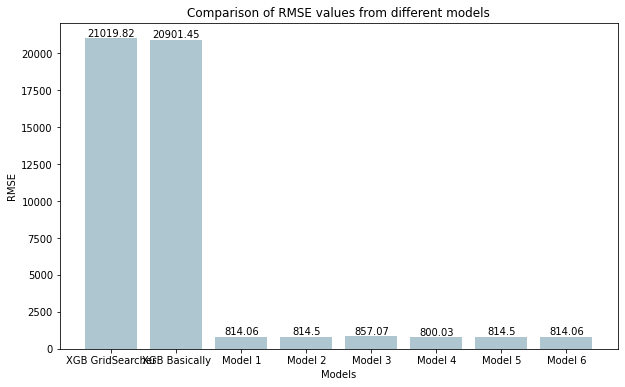

In [49]:
# Comparing RMSE of all models
rmse_dict = {
    'XGB GridSearcher': gs_rmse,
    'XGB Basically': basic_rmse,
    'Model 1': pytorch_rmse_6,
    'Model 2': pytorch_rmse_5,
    'Model 3': pytorch_rmse_3,
    'Model 4': pytorch_rmse_4,
    'Model 5': pytorch_rmse_5,
    'Model 6': pytorch_rmse_6
}

# Plot RMSE values
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_dict.keys(), rmse_dict.values(), color='#AEC6CF')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE values from different models')

# Add annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, round(yval, 2), ha='center', va='bottom')

plt.show()

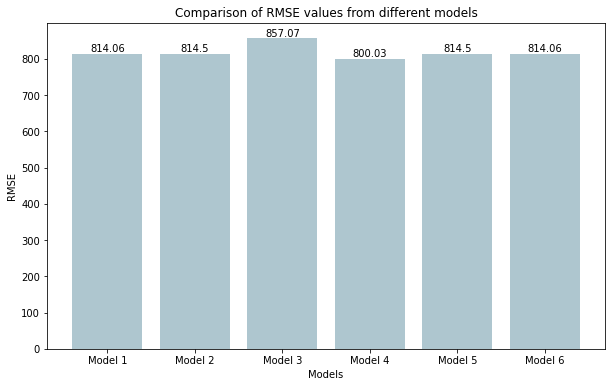

In [48]:
# Comparing RMSE of Pytorch models
rmse_dict = {
    'Model 1': pytorch_rmse_6,
    'Model 2': pytorch_rmse_5,
    'Model 3': pytorch_rmse_3,
    'Model 4': pytorch_rmse_4,
    'Model 5': pytorch_rmse_5,
    'Model 6': pytorch_rmse_6
}

# Plot RMSE values
plt.figure(figsize=(10, 6))
bars = plt.bar(rmse_dict.keys(), rmse_dict.values(), color='#AEC6CF')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE values from different models')

# Add annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, round(yval, 2), ha='center', va='bottom')

plt.show()